<a id='sec_Notebooks_qpe'></a> 
# Quantum Phase Estimation (QPE)

## Índice
- **[Ejemplo: Un solo autoestado en la ancilla](#sec_Notebooks_qpe_1)**
- **[¿y si no podemos preparar  un autoestado?](#sec_Notebooks_qpe_2)**
- **[Precisión](#sec_Notebooks_qpe_3)**
    - **[Solución](#sec_Notebooks_qpe_3.1)**

In [ ]:
# No olvidar que en "Google colab" hay que instalar qiskit

########################
# Instala versión 0.45.2
########################
# Importante, poner qiskit-aer en la misma linea de "pip install" para que coja la versión adecuada
try:
    import google.colab
    print("In colab, let's install things...")
    #
    !pip install qiskit[visualization]==0.45.2 qiskit-aer qiskit-ibm-runtime ipywidgets
except ImportError:
    print("NOT in colab")

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator

In [2]:
# Importamos el simulador. Con "method" le especificamos el método de simulación
simulador = AerSimulator(method = 'statevector')

<figure><center>
<img src="./Figuras/Fig-QPE-Circuito.png" align=center alt="" width='1000px'/>
</center></figure>


<a id='sec_Notebooks_qpe_1'></a>
## Ejemplo: Un solo autoestado en la ancilla  

Vamos a estudiar esta distribución analizando el operador unitario de fase
<br>

$$
U =  \begin{bmatrix} e^{2\pi i \phi_0} & 0 \\ 0 & e^{2\pi i\phi_1}\end{bmatrix} 
$$


que tiene por autoestados  $| 0 \rangle $ y $| 1\rangle $ con autovalores $e^{2\pi\phi_0}$ y $e^{2\pi \phi_1}$ respectivamente. 


Para programar este operador notamos que 
<br>

$$
U =  
\begin{bmatrix} e^{2\pi \phi_0} & 0 \\ 0 & e^{-2\pi i\phi_0}\end{bmatrix}
\begin{bmatrix} 1 & 0 \\ 0 & e^{2\pi i(\phi_0+\phi_1)}\end{bmatrix} = 
R_z(\theta = -4\pi \phi_0) \cdot P(\theta = 2\pi (\phi_1+\phi_0))
$$


El circuito requiere la versión *controlada* $CU^k$ de potencias de este operador

In [3]:
def c_U_gate(phi0, phi1, power):
    U = QuantumCircuit(1)        
    for _ in range(power):
        U.rz(-phi0*4*np.pi, 0)
        U.p((phi1+phi0)*2*np.pi, 0)
    U = U.to_gate()
    U.name = "c_U(%f ,%f)^%i" % (np.round(phi0,5), np.round(phi1,5),power)
    U = U.control()
    return U

Para poner a prueba el algoritmo vamos a seleccionar unos valores de $\theta_i$ de la forma  

$$
2^t \theta_i  = (a_i + \delta_i)
$$

In [4]:
t_seed=3

a0 = 2.
delta0 = 0.2
theta0 = (a0+delta0)*2.**(-t_seed) 

a1 = 3.
delta1 = 0.
theta1 =(a1+ delta1)*2.**(-t_seed) 

print('theta0=', theta0, ' ->  2^t*theta0 = a0 + delta0 = ', 2**t_seed*theta0 , ' , a0 =' ,int(2**t_seed*theta0), '=>', format(int(2**t_seed*theta0),'b').zfill(t_seed) )
print('theta1=', theta1, ' ->  2^t*theta1 = a1 + delta1 = ', 2**t_seed*theta1 , ' , a1 =' ,int(2**t_seed*theta1), '=>', format(int(2**t_seed*theta1),'b').zfill(t_seed) )

theta0= 0.275  ->  2^t*theta0 = a0 + delta0 =  2.2  , a0 = 2 => 010
theta1= 0.375  ->  2^t*theta1 = a1 + delta1 =  3.0  , a1 = 3 => 011


Construimos el circuito QPE

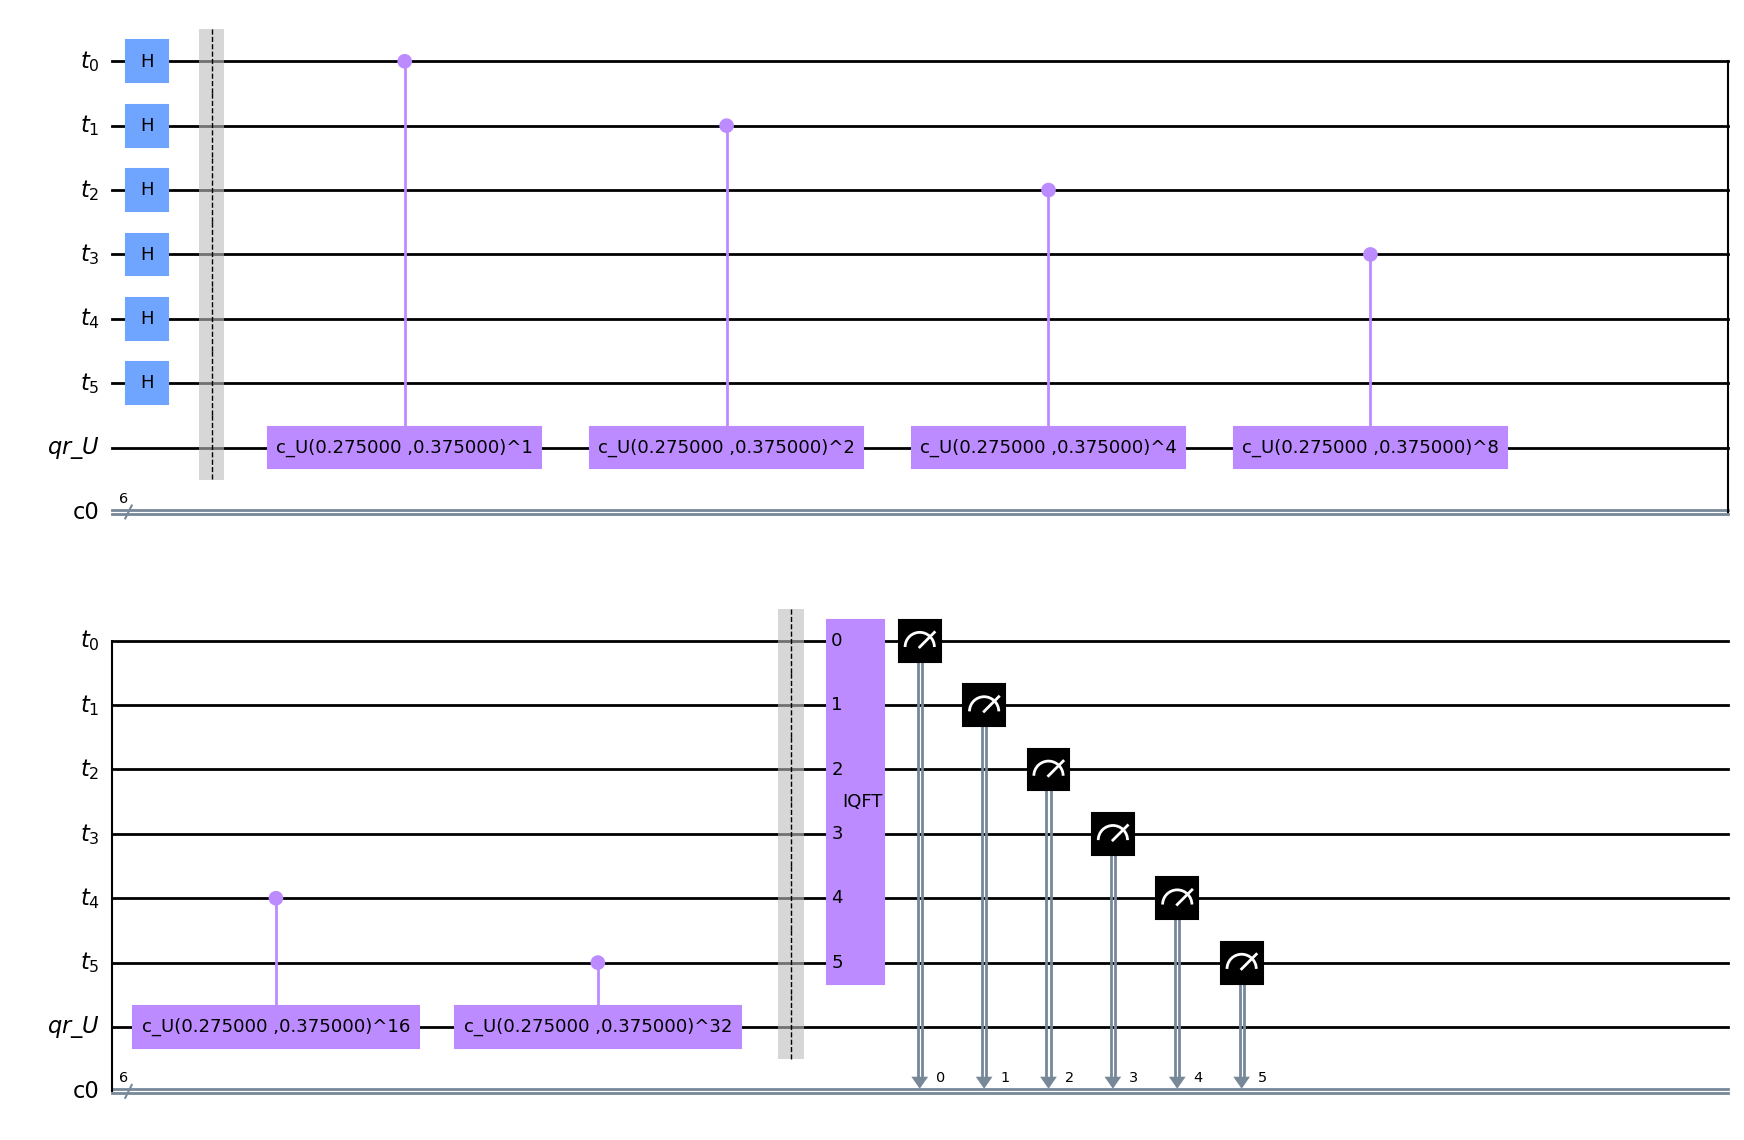

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

t = 6 # la dimensión del registro de evaluación 
n = 1 # la dimensiónd el espacio de representación del opeador U

qr_t = QuantumRegister(t,name="t")
qr_n = QuantumRegister(n,name="qr_U") # aquí 1 es la dimensión del espacio en el que opera U
cr_t = ClassicalRegister(t)

circuit_QPE = QuantumCircuit(qr_t, qr_n, cr_t)   

##########################################################################
#inicializamos la ancilla en un autoestado |u> =|0> o |u> = |1>
#circuit_QPE.x(qra)   
##########################################################################

circuit_QPE.h(range(t))
circuit_QPE.barrier()

# aplicamos los operadores controlados c-U^j 
for j in range(t):
    circuit_QPE.append(c_U_gate(theta0, theta1, 2**j), [qr_t[j]]+qr_n[:])
    

circuit_QPE.barrier()

# aplicamos la QFT^-1 que está definida en macro.py 
QFT_gate = QFT(t, inverse=True).to_gate() 
circuit_QPE.append(QFT_gate, qr_t)


circuit_QPE.measure(qr_t,cr_t)

circuit_QPE.draw(output="mpl")

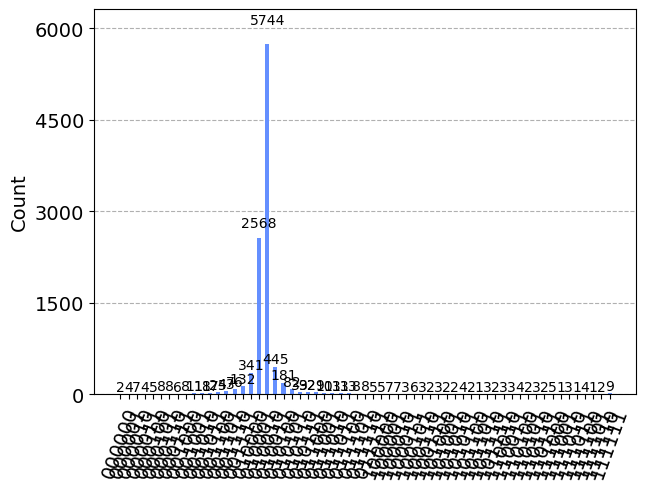

In [6]:
# transpilamos
t_circuit_QPE = transpile(circuit_QPE, backend = simulador)

# Ejecutamos la simulación con 1000 shots 
result = simulador.run(t_circuit_QPE, shots = 10000).result()
counts = result.get_counts()
plot_histogram(counts)

De aquí extraemos la aproximación que hemos obtenido. 

In [7]:
max(counts, key=counts.get)

'010010'

In [8]:
a_resultante = int(max(counts, key=counts.get),2)

# Seleccionamos el autovalor asociado a |u> 
theta = theta0  # si |0>
#theta = tetha1   # si |1>

print('el valor de phi original era =', theta)

print('la mejor aproximación al valor verdadero es a/2^t =', a_resultante*2**(-t))

print('el error relativo es delta/(2^t phi) =', (theta -a_resultante*2**(-t))/theta)

el valor de phi original era = 0.275
la mejor aproximación al valor verdadero es a/2^t = 0.28125
el error relativo es delta/(2^t phi) = -0.022727272727272645


<a id='sec_Notebooks_qpe_2'></a>
## ¿y si no podemos preparar  un autoestado?  

Si no podemos preparar un autovector para inicializar el qúbit ancilla en este estado, lo que podemos hacer es tener en cuenta que todo estado se puede expandir en la base de autovectores de un operador. 

Si $| \phi_0 \rangle$ y $| \phi_1 \rangle$ son los autovectores de nuestro operador $U$, cualquier estado $|\psi \rangle$ que metamos por el qúbit ancilla puede escribirse de la forma:

$$
|\psi \rangle = c_0 |\phi_0 \rangle + c_1 | \phi_1 \rangle
$$

In [9]:
t_seed = 3

a0 = 1.
delta0 = 0.1
phi0 = (a0+ delta0)*2.**(-t_seed) 

a1 = 3.
delta1 = 0.1
phi1 =(a1+ delta1)*2.**(-t_seed) 

print('phi0=', phi0, ' ->   2^t*phi0 = a0 + delta0 = ', 2**t_seed*phi0 , ' , a0 =' ,int(2**t_seed*phi0), '=>', format(int(2**t_seed*phi0),'b').zfill(t_seed) )
print('phi1=', phi1, ' ->   2^t*phi1 = a1 + delta1 = ', 2**t_seed*phi1 , ' , a1 =' ,int(2**t_seed*phi0), '=>', format(int(2**t_seed*phi1),'b').zfill(t_seed) )


phi0= 0.1375  ->   2^t*phi0 = a0 + delta0 =  1.1  , a0 = 1 => 001
phi1= 0.3875  ->   2^t*phi1 = a1 + delta1 =  3.1  , a1 = 1 => 011


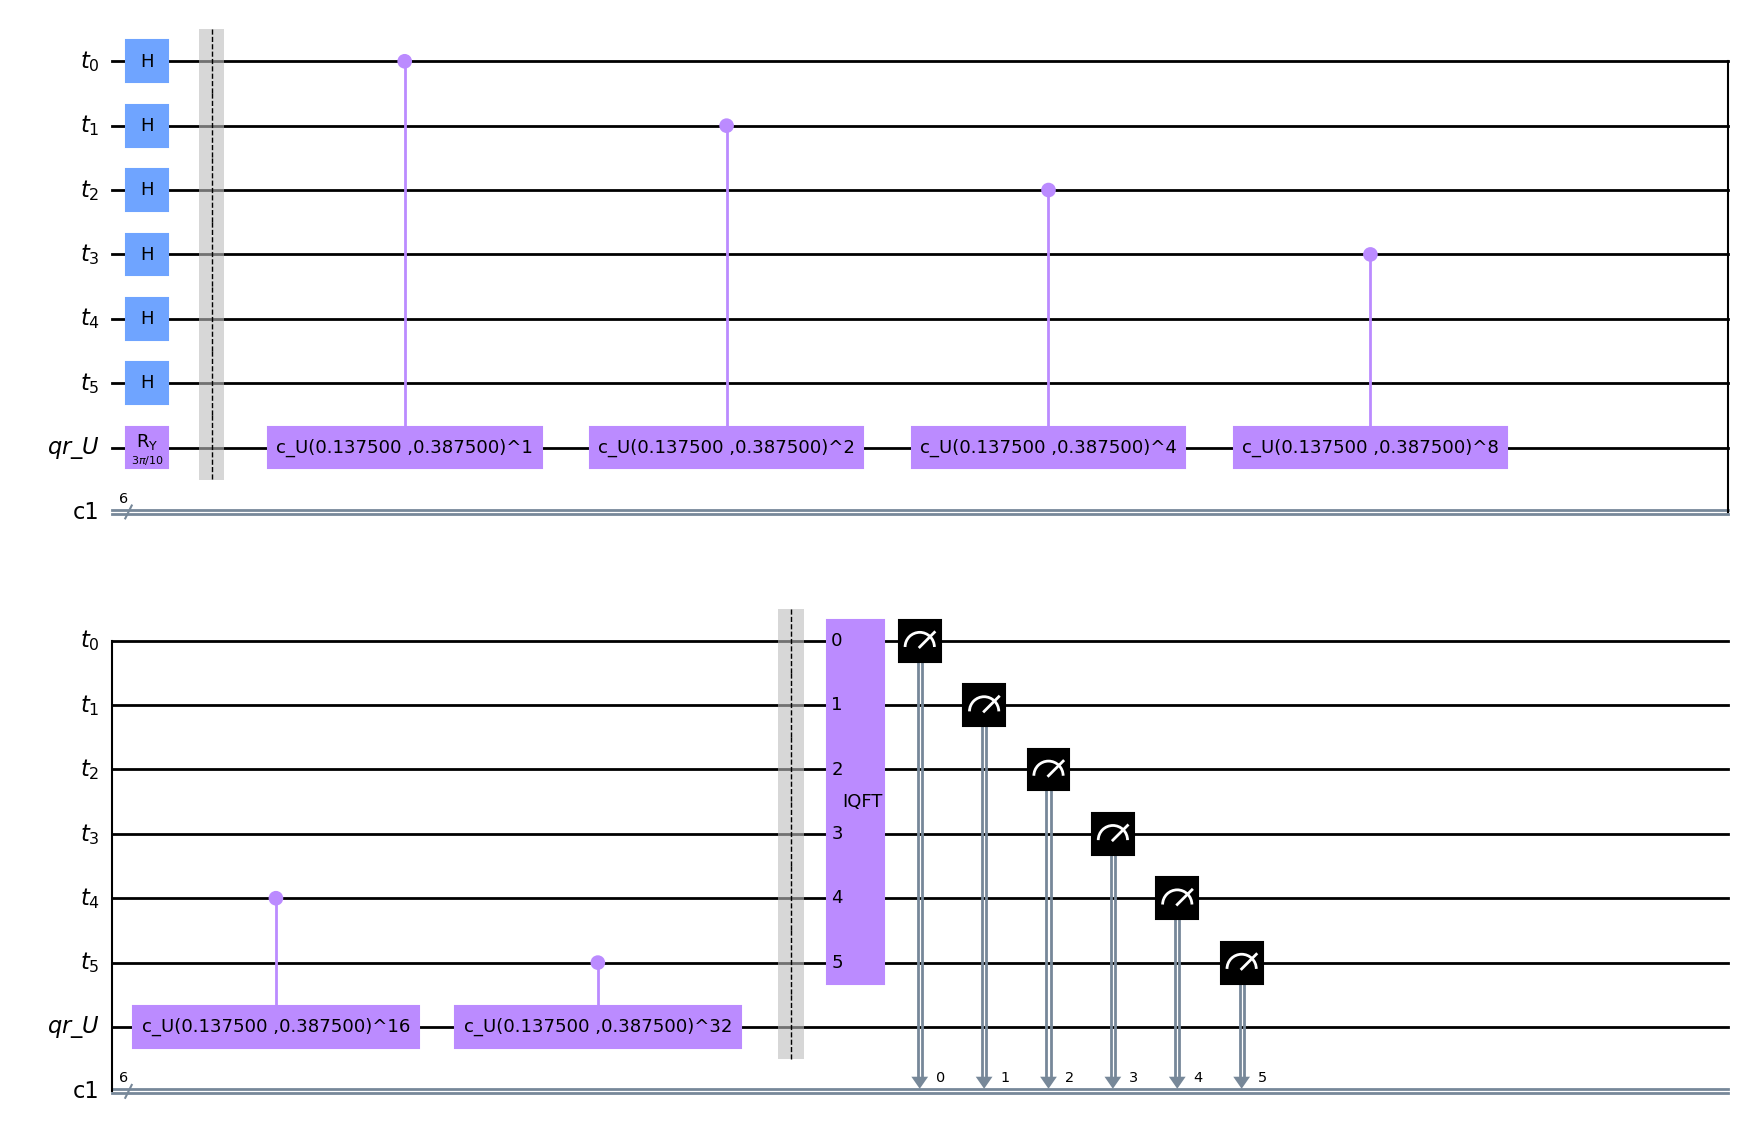

In [10]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

t = 6 # la dimensión del registro de evaluación 
n = 1 # la dimensiónd el espacio de representación del opeador U

qr_t=QuantumRegister(t, name="t")
qr_n=QuantumRegister(n, name="qr_U") # aquí 1 es la dimensión del espacio en el que opera U
cr_t=ClassicalRegister(t)

circuit_QPE_2 = QuantumCircuit(qr_t, qr_n, cr_t)   

##########################################################################
#inicializamos la ancilla en una combinación cos(th/2)|0> + sin(th/2)|1>
theta = 2*np.pi*0.15 
circuit_QPE_2.ry(theta, qr_n) 
##########################################################################

circuit_QPE_2.h(range(t))
circuit_QPE_2.barrier()

# aplicamos los operadores controlados c-U^j 
for j in range(t):
    circuit_QPE_2.append(c_U_gate(phi0, phi1, 2**j),[qr_t[j]]+qr_n[:])
#    circuit_QPE_2.cp(2*np.pi*phi1*(2**j), qr_t[j], qr_a); # This is C-U
    

circuit_QPE_2.barrier()

# aplicamos la QFT^-1 que está definida en macro.py 
QFT_gate = QFT(t, inverse=True).to_gate() 
circuit_QPE_2.append(QFT_gate, qr_t)

circuit_QPE_2.measure(qr_t,cr_t)

circuit_QPE_2.draw(output="mpl")

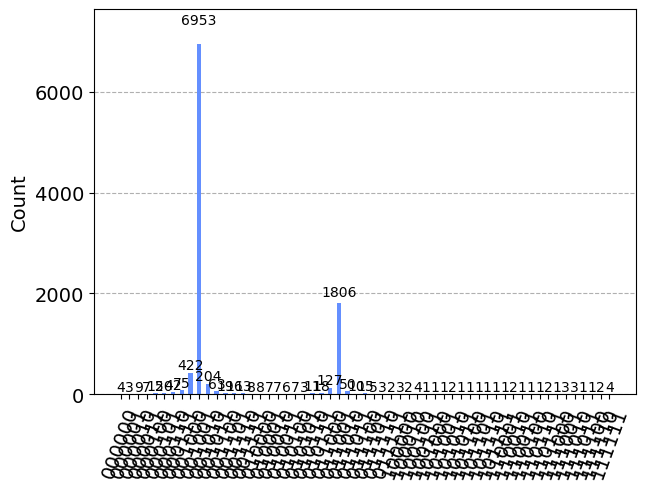

In [11]:
# transpilamos
t_circuit_QPE_2 = transpile(circuit_QPE_2, backend = simulador)

# Ejecutamos la simulación con 1000 shots 
result_2 = simulador.run(t_circuit_QPE_2, shots = 10000).result()
counts_2 = result_2.get_counts()
plot_histogram(counts_2)

Vemos que tenemos dos picos correspondientes a los dos autovalores. La altura de los picos está ponderada por el cuadrado del coeficiente correspondiente de la expansión del estado del qúbit ancilla en la base de autovectores (por $|c_0|^2$ y $|c_1|^2$):
<br>

$$
|\psi \rangle = c_0 |\phi_0 \rangle + c_1 | \phi_1 \rangle
$$

<a id='sec_Notebooks_qpe_3'></a>
## Precisión  

Veamos otro ejemplo más. En este caso cojamos como nuestro operador $U$, una puerta $P$ con $\theta = 1/3$:

$$
U =  P(\theta = 2\pi /3 ) =  
\begin{bmatrix} 1 & 0 \\ 0 & e^{2\pi/3}\end{bmatrix} 
$$

Es decir, si tomamos el qúbit ancilla en el estado $| 1 \rangle$ tendremos que obtener $\theta = 1/3$

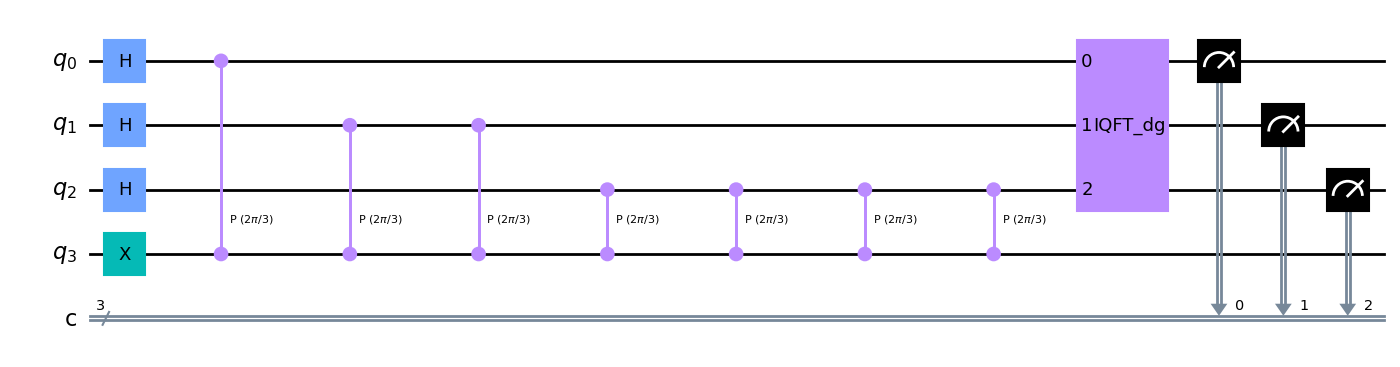

In [12]:
# Create and set up circuit
t = 3 # la dimensión del registro de evaluación 
n = 1 # la dimensiónd el espacio de representación del opeador U
circuit_QPE_P = QuantumCircuit(t+n, t)

# Apply H-Gates to counting qubits:
for qubit in range(t):
    circuit_QPE_P.h(qubit)

# Prepare our eigenstate |psi>:
circuit_QPE_P.x(t)

# Do the controlled-U operations:
angle = 2*np.pi/3
repetitions = 1
for counting_qubit in range(t):
    for i in range(repetitions):
        circuit_QPE_P.cp(angle, counting_qubit, t);
    repetitions *= 2

# Do the inverse QFT:
circuit_QPE_P = circuit_QPE_P.compose(QFT(t, inverse=True), [i for i in range(t)])

# Measure of course!
for i in range(t):
    circuit_QPE_P.measure(i,i)

circuit_QPE_P.draw(output = 'mpl')

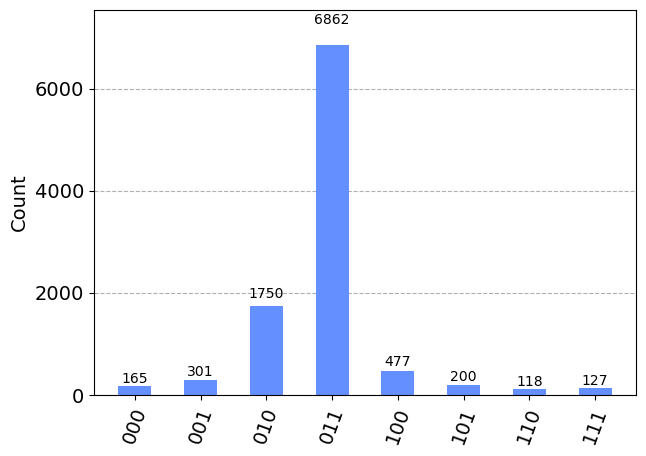

In [13]:
# transpilamos
t_circuit_QPE_P = transpile(circuit_QPE_P, backend = simulador)

# Ejecutamos la simulación con 1000 shots 
result_p = simulador.run(t_circuit_QPE_P, shots = 10000).result()
counts_p = result_p.get_counts()
plot_histogram(counts_p)

Esperamos el resultado $\theta$ = 0.3333... y vemos que nuestros resultados más probables son 010(bin) = 2(dec) y 011(bin) = 3(dec). Estos dos resultados nos dirían que $\theta$ = 0,25 (desviación del 25%) y $\theta$ = 0,375 (desviación del 13%) respectivamente. El verdadero valor de $\theta$ se encuentra entre los valores que podemos obtener de nuestros bits de conteo, y esto nos da incertidumbre e imprecisión. 

<a id='sec_Notebooks_qpe_3.1'></a>
### Solución

Para obtener más precisión simplemente añadimos más qubits contadores. Vamos a añadir dos qubits contadores más:

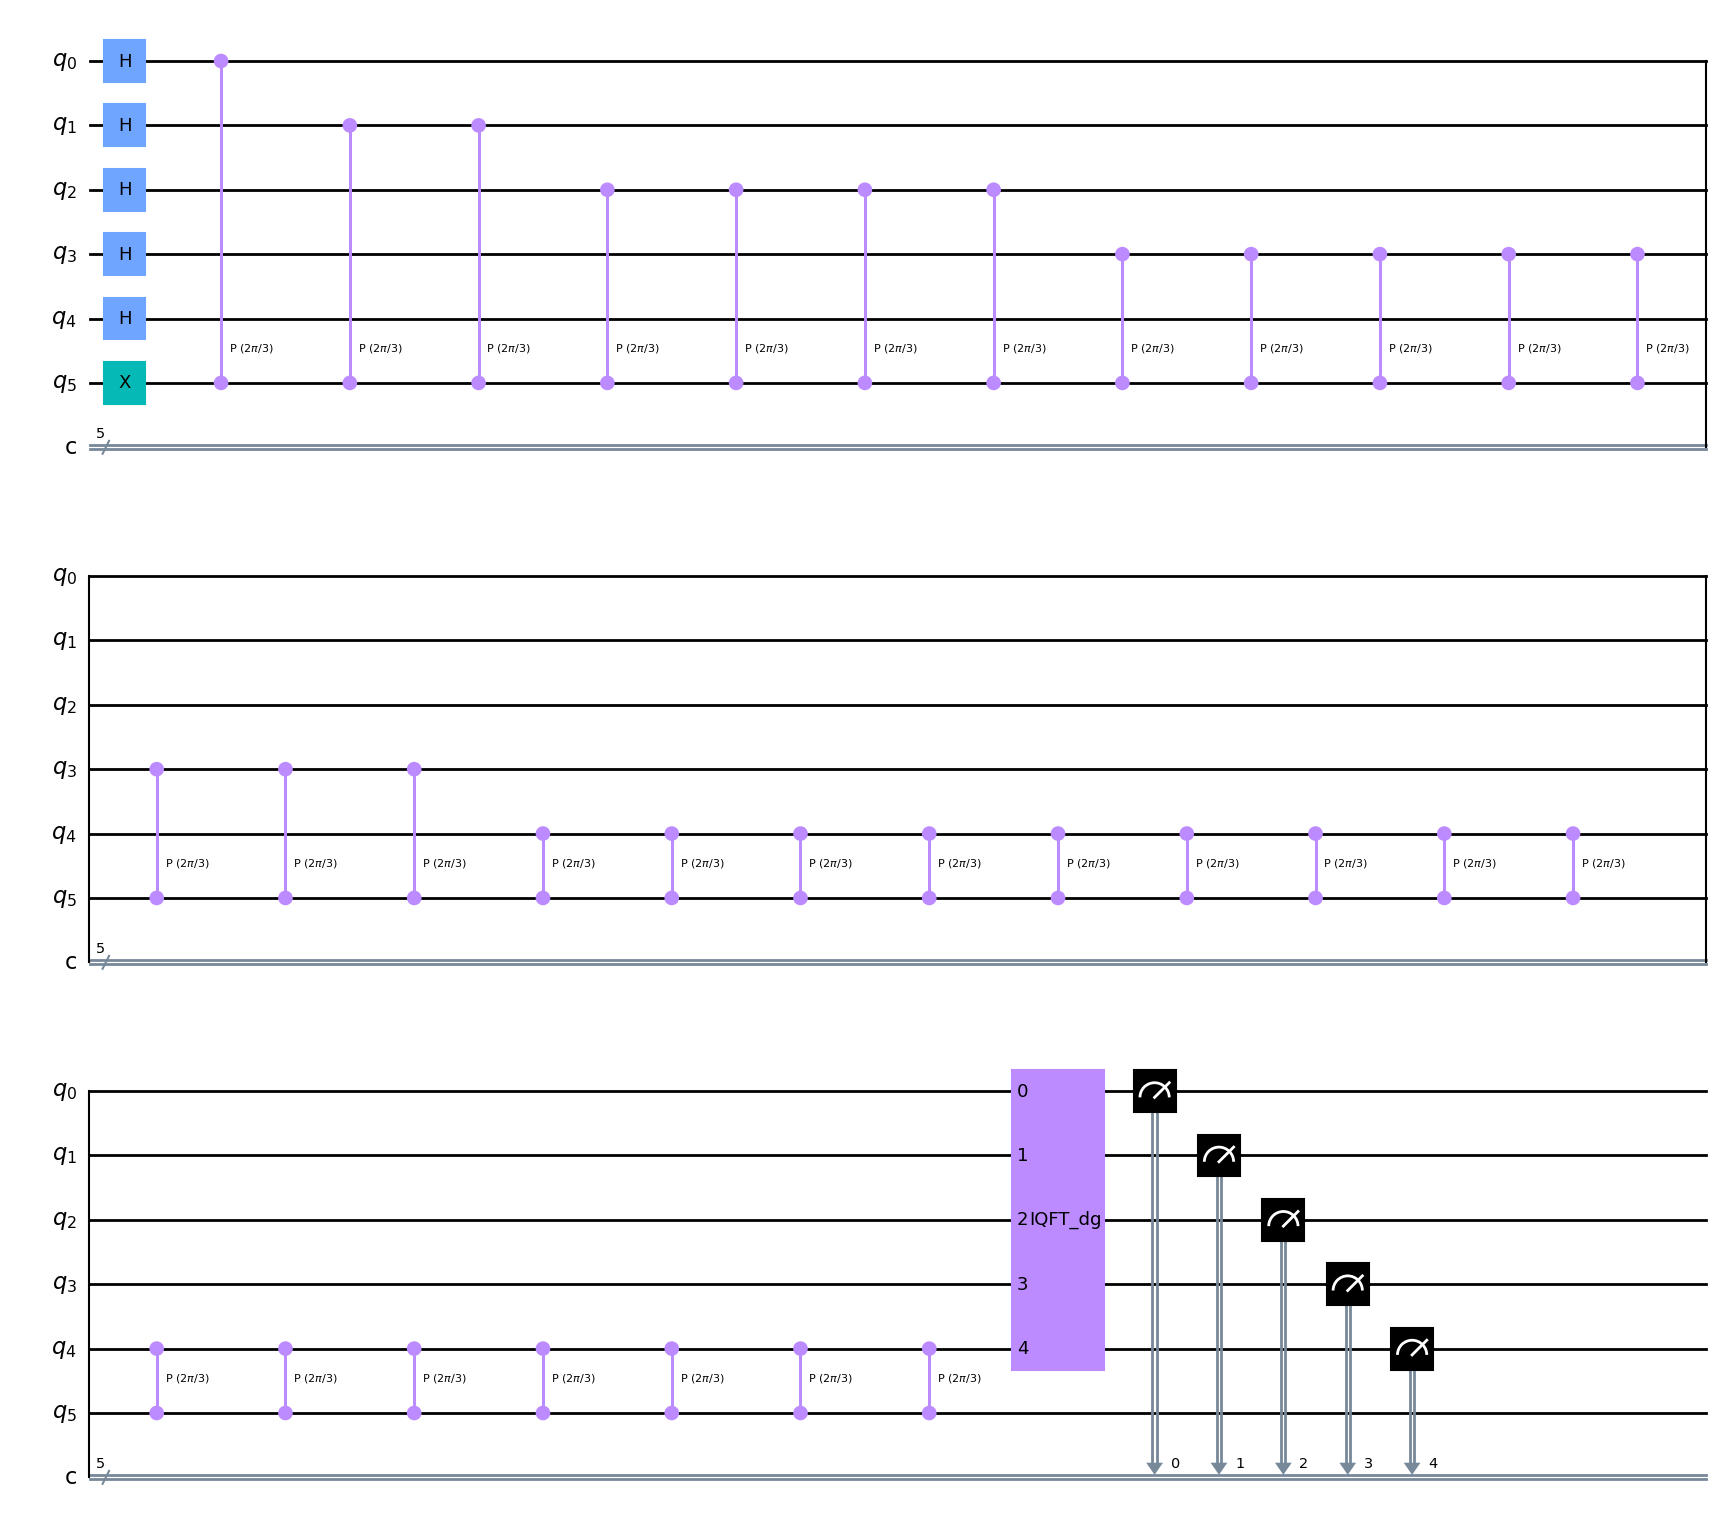

In [14]:
t = 5 # la dimensión del registro de evaluación 
n = 1 # la dimensiónd el espacio de representación del opeador U
circuit_QPE_P = QuantumCircuit(t+n, t)

# Apply H-Gates to counting qubits:
for qubit in range(t):
    circuit_QPE_P.h(qubit)

# Prepare our eigenstate |psi>:
circuit_QPE_P.x(t)

# Do the controlled-U operations:
angle = 2*np.pi/3
repetitions = 1
for counting_qubit in range(t):
    for i in range(repetitions):
        circuit_QPE_P.cp(angle, counting_qubit, t);
    repetitions *= 2

# Do the inverse QFT:
circuit_QPE_P = circuit_QPE_P.compose(QFT(t, inverse=True), [i for i in range(t)])

# Measure of course!
for i in range(t):
    circuit_QPE_P.measure(i,i)

circuit_QPE_P.draw(output = 'mpl')

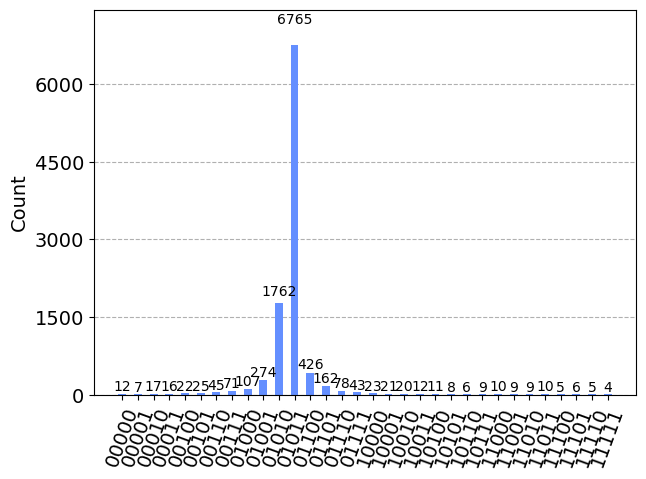

In [15]:
# transpilamos
t_circuit_QPE_P = transpile(circuit_QPE_P, backend = simulador)

# Ejecutamos la simulación con 1000 shots 
result_p = simulador.run(t_circuit_QPE_P, shots = 10000).result()
counts_p = result_p.get_counts()
plot_histogram(counts_p)

Las dos medidas más probables son ahora 01011 (11 decimal) y 
01010 (decimal 10). Medir estos resultados nos diría es:

$$ 
\theta = 11/2^5 = 0.344 
$$

$$ 
\theta = 10/2^5 = 0.313 
$$

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table